In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

### Import cleaned datasets

In [11]:
df_train_s = pd.read_csv(r'df_train.csv')

In [12]:
df_train_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148387 entries, 0 to 148386
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     148387 non-null  object 
 1   condition    148387 non-null  object 
 2   rating       148387 non-null  float64
 3   usefulCount  148387 non-null  int64  
 4   review       148386 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.7+ MB


In [13]:
#drop Nan value
df_train_s.dropna(inplace=True)

In [14]:
df_train_s.reset_index(inplace=True)

In [15]:
df_train_s['condition']


0                                 ADHD
1                        Birth Control
2                        Birth Control
3         Benign Prostatic Hyperplasia
4              Emergency Contraception
                      ...             
148381                   Birth Control
148382                 Nausea/Vomiting
148383            Rheumatoid Arthritis
148384             Underactive Thyroid
148385           Constipation, Chronic
Name: condition, Length: 148386, dtype: object

In [16]:
condition_list=df_train_s['condition'].tolist()

In [17]:
corpus_train=df_train_s.review
# corpus_test=df_test_s.review

In [18]:
#custom stopwords
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't",
     "mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound',]
for j in a:
    stop.add(j)

### CountVectorizer

In [19]:
# Create a CountVectorizer for parsing/counting words
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.8)
# cv = CountVectorizer(ngram_range=(2, 2), min_df=10, max_df=0.8)

cv.fit(corpus_train)

CountVectorizer(max_df=0.8, min_df=0.01, ngram_range=(1, 2))

In [20]:
doc_word = cv.transform(corpus_train).transpose()

In [21]:
pd.DataFrame(doc_word.toarray(), cv.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,148376,148377,148378,148379,148380,148381,148382,148383,148384,148385
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolutely,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ache,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acne,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
active,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
corpus = matutils.Sparse2Corpus(doc_word)

In [23]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [24]:
len(id2word)

703

### LDA

In [25]:
lda = models.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, passes=10)

In [26]:
lda.print_topics()

[(0,
  '0.017*"not" + 0.015*"effect" + 0.014*"year" + 0.014*"pain" + 0.014*"side" + 0.013*"take" + 0.013*"side effect" + 0.013*"taking" + 0.011*"time" + 0.011*"work"'),
 (1,
  '0.024*"period" + 0.023*"pill" + 0.017*"not" + 0.016*"month" + 0.016*"weight" + 0.015*"no" + 0.012*"first" + 0.012*"control" + 0.012*"year" + 0.010*"got"')]

In [27]:
lda_corpus = lda[corpus]
lda_corpus

In [28]:
lda_docs = [doc for doc in lda_corpus]

In [29]:
lda_docs[0:5]

[[(0, 0.8338631), (1, 0.16613695)],
 [(0, 0.04355601), (1, 0.95644397)],
 [(0, 0.016278263), (1, 0.9837218)],
 [(0, 0.97721654), (1, 0.02278342)],
 [(0, 0.18145521), (1, 0.8185448)]]

In [30]:
len(lda_docs)

148386

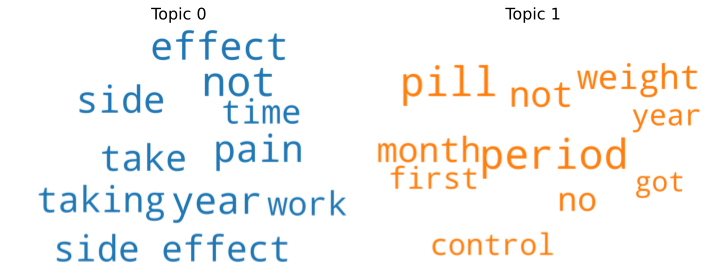

<Figure size 432x288 with 0 Axes>

In [31]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig(r'fig/wc_bigram_lda-2.svg')

In [32]:
lda1 = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)

In [33]:
lda1.print_topics()

[(0,
  '0.035*"period" + 0.025*"pill" + 0.018*"not" + 0.017*"month" + 0.016*"control" + 0.015*"no" + 0.014*"birth" + 0.013*"birth control" + 0.013*"year" + 0.012*"first"'),
 (1,
  '0.068*"effect" + 0.066*"side" + 0.060*"side effect" + 0.023*"no" + 0.019*"weight" + 0.017*"taking" + 0.015*"not" + 0.014*"started" + 0.012*"lb" + 0.012*"lost"'),
 (2,
  '0.032*"pain" + 0.018*"not" + 0.013*"take" + 0.012*"time" + 0.012*"work" + 0.012*"took" + 0.012*"hour" + 0.011*"day" + 0.010*"get" + 0.010*"back"'),
 (3,
  '0.021*"year" + 0.018*"anxiety" + 0.018*"feel" + 0.017*"not" + 0.015*"life" + 0.015*"taking" + 0.014*"take" + 0.014*"sleep" + 0.013*"like" + 0.012*"medication"')]

In [34]:
all_topics = lda1.get_document_topics(corpus)
all_topics

In [35]:
num_docs = len(all_topics)

In [36]:
num_topics=4

lda_scores = np.empty([num_docs, num_topics])

for i in range(0, num_docs):
    lda_scores[i] = np.array(all_topics[i]).transpose()[0]

ValueError: could not broadcast input array from shape (3,) into shape (4,)

In [38]:
lda_corpus1 = lda1[corpus]
lda_corpus1

In [39]:
lda_docs1 = [doc for doc in lda_corpus1]

In [41]:
lda_docs1[0:5]

[[(0, 0.016229484), (2, 0.41228127), (3, 0.5665088)],
 [(0, 0.6741856), (1, 0.3169032)],
 [(0, 0.9802756)],
 [(1, 0.3716231), (2, 0.61291707)],
 [(0, 0.4044061), (1, 0.017239654), (2, 0.5612469), (3, 0.017107384)]]

In [42]:
len(lda_docs1)

148386

In [43]:
def dominant_topic(ldamodel, corpus, texts):
     #Function to find the dominant topic in each review
     sent_topics_df = pd.DataFrame() 
     # Get main topic in each review
     for i, row in enumerate(ldamodel[corpus]):
         row = sorted(row, key=lambda x: (x[1]), reverse=True)
         # Get the Dominant topic, Perc Contribution and Keywords for each review
         for j, (topic_num, prop_topic) in enumerate(row):
             if j == 0:  # => dominant topic
                 wp = ldamodel.show_topic(topic_num,topn=4)
                 topic_keywords = ", ".join([word for word, prop in wp])
                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
             else:
                 break
     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     contents = pd.Series(texts)
     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
     return(sent_topics_df)

df_dominant_topic = dominant_topic(ldamodel=lda1, corpus=corpus, texts=df_train_s['review']) 
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,review
0,3.0,0.5674,"year, anxiety, feel, not",son halfway fourth intuniv became concerned be...
1,0.0,0.6742,"period, pill, not, month",used take another contraceptive pill cycle hap...
2,0.0,0.9803,"period, pill, not, month",first time using form birth control glad went ...
3,2.0,0.6129,"pain, not, take, time",nd started work rock hard erection however exp...
4,2.0,0.5612,"pain, not, take, time",pulled cummed bit took plan b hour later took ...


In [44]:
#export topic keywords to csv file for later use
export_csv = df_dominant_topic.to_csv(r'df_dominant_topic.csv', index = None, header=True)

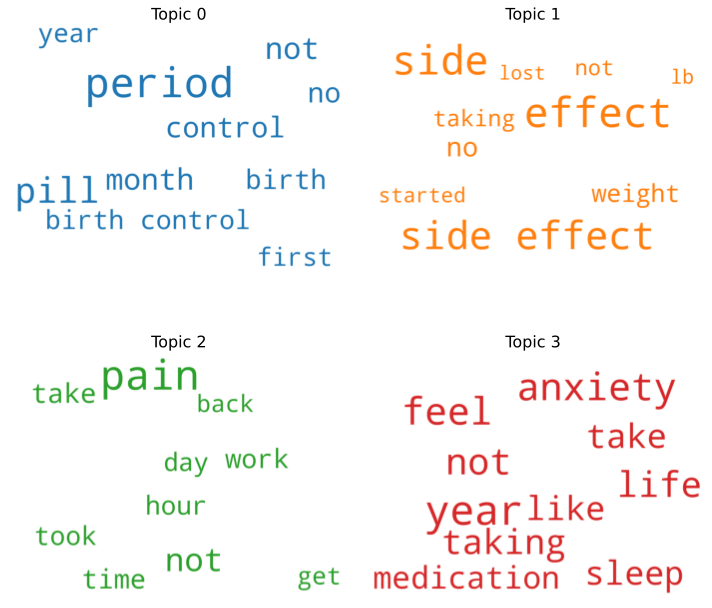

<Figure size 432x288 with 0 Axes>

In [45]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics1 = lda1.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words1 = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words1, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig(r'fig/wc_bigram_lda-4.svg')

In [ ]:
lda2 = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10)

In [ ]:
lda2.print_topics()

In [ ]:
lda_corpus2 = lda2[corpus]
lda_corpus2

In [ ]:
lda_docs2 = [doc for doc in lda_corpus2]

In [ ]:
lda_docs2[0:5]

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics2 = lda2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(12,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words2 = dict(topics2[i][1])
    cloud.generate_from_frequencies(topic_words2, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig(r'fig/wc_bigram_lda-6.svg')